In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize 
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merge the two datasets together, so we can make sure we maniuplate data the same way for traning and test datasets. 

In [3]:
alldata = pd.concat([train,test])
alldata = alldata.reset_index(drop=True)
cutpoint = train.shape[0]

## Part 1 Feature Engineering 

Let us take care of the nested json columns firstly. 

In [4]:
nested_variables = ["device","geoNetwork","totals","trafficSource"]
for i in nested_variables: 
    alldata[i]=alldata[i].apply(lambda x: json.loads(x))
    alldata = pd.concat([alldata,json_normalize(alldata[i])], axis=1)
alldata = alldata.drop(nested_variables,axis=1)

Drop the variables that only provided constant value acrossed observations. 

In [5]:
droplist=[]
variables = list(alldata.columns)

for i in variables : 
    a = pd.DataFrame(alldata[i].value_counts())
    if a.iloc[0,0]==len(alldata):
        droplist.append(i)
alldata= alldata.drop(droplist, axis=1)

In [6]:
alldata.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'browser', 'deviceCategory',
       'isMobile', 'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'transactionRevenue', 'adContent',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.isVideoAd', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'campaign', 'campaignCode', 'isTrueDirect',
       'keyword', 'medium', 'referralPath', 'source'],
      dtype='object')

### 1.1 Non-categorical Data Processing 

In [7]:
for i in list(alldata.columns):
    if type(alldata[i].iloc[0]) != str:
        print (i)

date
visitId
visitNumber
visitStartTime
isMobile
transactionRevenue
adContent
adwordsClickInfo.adNetworkType
adwordsClickInfo.gclId
adwordsClickInfo.isVideoAd
adwordsClickInfo.page
adwordsClickInfo.slot
campaignCode
isTrueDirect
referralPath


In [6]:
#SessionId and VisitId are not usable in the data analysis process, since we can know the frequency of sessions by count the 
#frequncy of fullvistorId. So let us delete these two columns for now. 
alldata=alldata.drop(["sessionId","visitId"],axis=1)

Date and visitStartdate are basically the same thing for us, 
except the start date gives us more information about time in a day. 

In [7]:
import datetime 

In [8]:
alldata['date'] =  pd.to_datetime(alldata['date'], format='%Y%m%d')
alldata['weekofday']= alldata['date'].dt.dayofweek
alldata["monthofyear"]=alldata['date'].dt.month 

Let us try to keep the visitStartTime this time but next time we will process it in to time bins during a day. 

In [11]:
#The visitnumber is very skewed. Right now let us take bins for this variables. 

In [9]:
visitNumberBins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3),(3,4),(4,5),(5,10),(10,1000)])
alldata['visitNumber'] = pd.cut(alldata['visitNumber'],visitNumberBins,labels=True)
alldata["visitNumber"]=alldata['visitNumber'].cat.rename_categories(["1","2","3","4","5","6-10","morethan10"])

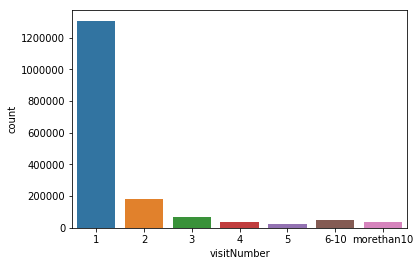

In [13]:
sns.countplot(x='visitNumber',data=alldata)

In [14]:
alldata.isnull().sum()

channelGrouping                         0
date                                    0
fullVisitorId                           0
visitNumber                             0
visitStartTime                          0
browser                                 0
deviceCategory                          0
isMobile                                0
operatingSystem                         0
city                                    0
continent                               0
country                                 0
metro                                   0
networkDomain                           0
region                                  0
subContinent                            0
bounces                            836759
hits                                    0
newVisits                          400907
pageviews                             239
transactionRevenue                1696822
adContent                         1643600
adwordsClickInfo.adNetworkType    1633063
adwordsClickInfo.gclId            

In [10]:
alldata["hits"] = alldata["hits"].astype(int)

In [11]:
hitsBins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10),(10,500)])
alldata['hits'] = pd.cut(alldata['hits'],hitsBins,labels=True)
alldata["hits"]=alldata['hits'].cat.rename_categories(["1","2","3","4","5","6","7","8","9","10","morethan10"])

In [17]:
alldata['hits'].value_counts()/len(alldata)*100

1             50.579248
2             13.902351
morethan10     9.835296
3              7.869349
4              4.734136
5              3.728012
6              2.727682
7              2.232405
8              1.739528
9              1.463353
10             1.188641
Name: hits, dtype: float64

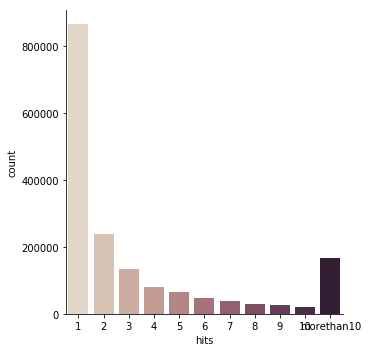

In [18]:
sns.catplot(x="hits", kind="count", palette="ch:.25", data=alldata)

In [12]:
alldata["adwordsClickInfo.page"].fillna(0,inplace=True)

In [20]:
alldata["adwordsClickInfo.page"].value_counts()/len(alldata)*100

0     95.593727
1      4.326605
2      0.061873
3      0.010068
4      0.004683
5      0.001756
6      0.000585
7      0.000351
9      0.000176
14     0.000059
8      0.000059
12     0.000059
Name: adwordsClickInfo.page, dtype: float64

In [13]:
alldata["adwordsClickInfo.page"]=alldata["adwordsClickInfo.page"].astype(int)

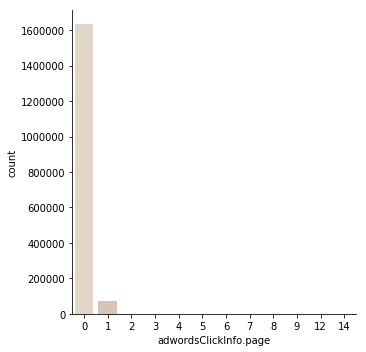

In [22]:
sns.catplot(x="adwordsClickInfo.page", kind="count", palette="ch:.25", data=alldata)

<font color=pink>Let us keep like this for now. I don't know how to make this data less skewed.</font> 

In [14]:
alldata["pageviews"].fillna(0,inplace=True)

In [15]:
alldata["pageviews"] = alldata["pageviews"].astype(int)

In [25]:
max(alldata["pageviews"])

500

In [26]:
alldata["pageviews"].value_counts()/len(alldata)*100


1      51.297139
2      14.622056
3       8.364626
4       5.073121
5       3.788011
6       2.793418
7       2.209810
8       1.731860
9       1.413831
10      1.125539
11      0.966437
12      0.785208
13      0.675686
14      0.582204
15      0.498262
16      0.425736
17      0.374575
18      0.328448
19      0.280858
20      0.246380
21      0.225658
22      0.201775
23      0.173502
24      0.156878
25      0.139609
26      0.131063
27      0.111395
28      0.107239
29      0.086868
30      0.084000
         ...    
142     0.000059
144     0.000059
151     0.000059
154     0.000059
155     0.000059
159     0.000059
162     0.000059
164     0.000059
166     0.000059
168     0.000059
171     0.000059
173     0.000059
174     0.000059
186     0.000059
189     0.000059
190     0.000059
191     0.000059
194     0.000059
195     0.000059
196     0.000059
197     0.000059
198     0.000059
200     0.000059
201     0.000059
208     0.000059
210     0.000059
213     0.000059
215     0.0000

In [16]:
pageviewsBins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10),(10,500)])
alldata['pageviews'] = pd.cut(alldata['pageviews'],pageviewsBins,labels=True,include_lowest=True)
alldata["pageviews"]=alldata['pageviews'].cat.rename_categories(["0 and 1","2","3","4","5","6","7","8","9","10","morethan10"])

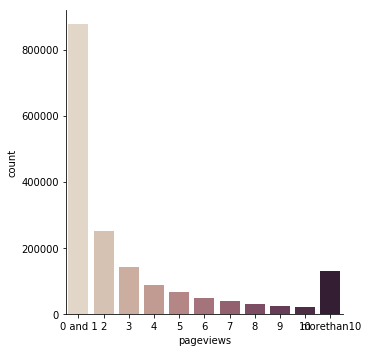

In [28]:
sns.catplot(x="pageviews", kind="count", palette="ch:.25", data=alldata)

In [18]:
alldata["transactionRevenue"].fillna(0,inplace=True)

In [19]:
alldata["transactionRevenue"] = alldata["transactionRevenue"].astype("float")

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


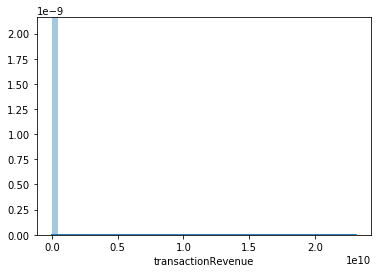

In [31]:
sns.distplot(alldata["transactionRevenue"])

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


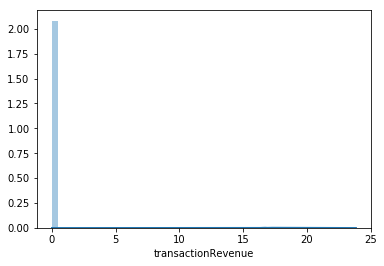

In [32]:
sns.distplot(np.log(alldata["transactionRevenue"]+1))

In [20]:
alldata["transactionRevenue"]=np.log(alldata["transactionRevenue"]+1)

<font color=pink>Should we treat the hits and pageviews the same way as we treat the transactionRevenue? </font> 

### 1.2 Categorical Data Processing 

In [34]:
alldata.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'browser', 'deviceCategory', 'isMobile',
       'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'transactionRevenue', 'adContent',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.isVideoAd', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'campaign', 'campaignCode', 'isTrueDirect',
       'keyword', 'medium', 'referralPath', 'source', 'weekofday',
       'monthofyear'],
      dtype='object')

In [ ]:
alldata["channelGrouping"].value_counts()

In [21]:
browser=["Chrome","Safari","Firefox","Internet Explorer","Android Webview","Edge","Samsung Internet","Opera Mini","Safari (in-app)","UC Browser","YaBrowser"]
alldata.ix[~alldata.browser.isin(browser), 'browser'] = 'Others'
alldata.browser.value_counts()/len(alldata)*100

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Chrome               68.666545
Safari               18.273034
Firefox               3.737260
Internet Explorer     2.076522
Android Webview       2.005810
Edge                  1.202514
Samsung Internet      0.924408
Others                0.913930
Opera Mini            0.879101
Safari (in-app)       0.831627
UC Browser            0.311004
YaBrowser             0.178244
Name: browser, dtype: float64

In [ ]:
alldata["deviceCategory"].value_counts()

In [22]:
os = ["Windows","Macintosh","Android","iOS","Linux","Chrome OS","(not set)","Windows Phone",
     "Samesung","Tizen","BlackBerry","OS/2"]
alldata.ix[~alldata.operatingSystem.isin(os), 'operatingSystem'] = 'Others'
alldata.operatingSystem.value_counts()/len(alldata)*100
#Let us only cares about the categories that more than 0.01% 

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Windows          36.276215
Macintosh        25.669057
Android          17.524997
iOS              12.839036
Linux             3.744636
Chrome OS         3.003974
(not set)         0.691608
Windows Phone     0.098049
Others            0.078790
Tizen             0.041502
BlackBerry        0.020488
OS/2              0.011649
Name: operatingSystem, dtype: float64

In [ ]:
alldata["isMobile"].value_counts()

In [ ]:
alldata["region"].value_counts()/len(alldata)*100
#use hashing to treat region 

In [23]:
temp = pd.DataFrame(alldata["metro"].value_counts()/len(alldata)*100)
dic=list(temp.index)
metrodic=dic[:20]
alldata.ix[~alldata.metro.isin(metrodic), 'metro'] = 'Others'
alldata.metro.value_counts()/len(alldata)*100

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


not available in demo dataset        54.612117
(not set)                            22.647522
San Francisco-Oakland-San Jose CA    10.697245
New York NY                           2.951350
London                                1.383978
Others                                1.382104
Los Angeles CA                        1.167978
Chicago IL                            0.895608
Seattle-Tacoma WA                     0.892740
Austin TX                             0.426672
Washington DC (Hagerstown MD)         0.410984
Boston MA-Manchester NH               0.343492
Dallas-Ft. Worth TX                   0.338750
Houston TX                            0.333892
Atlanta GA                            0.319843
Detroit MI                            0.264409
JP_KANTO                              0.254224
San Diego CA                          0.203941
Philadelphia PA                       0.166068
Roanoke-Lynchburg VA                  0.156526
Denver CO                             0.150556
Name: metro, 

In [ ]:
alldata["continent"].value_counts()

In [ ]:
a=alldata["city"].value_counts()/len(alldata)*100
a[:20].sum()   #hashing 

In [ ]:
a=alldata["country"].value_counts()/len(alldata)*100
a[:20].sum()   #hashing 

In [24]:
alldata["bounces"].fillna(0, inplace=True)
#fillna based on the meanings of features. No bounce - should be 0, not new visits- should be 0

In [25]:
alldata["newVisits"].fillna(0,inplace=True)

In [ ]:
alldata["networkDomain"].value_counts()/len(alldata)*100

In [26]:
#Too many values inside networkdDomain. Let us create clusters for it. 
alldata["networkDomainList"] = alldata["networkDomain"].apply(lambda x: x.translate(str.maketrans("."," ")))
corpurs_networkDomain = alldata["networkDomainList"].tolist()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_matrix = tfidf_model.fit_transform(corpurs_networkDomain) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " corpurs and " + str(tfidf_matrix.shape[1]) + " terms.")
from sklearn.cluster import KMeans

num_clusters = 50
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
alldata["netDomain_clusters"]=clusters

In total, there are 1708337 corpurs and 38461 terms.


In [ ]:
alldata["subContinent"].value_counts()
#Let us leave it what it is for now. 

In [27]:
alldata["adContent"].fillna("None",inplace=True)

In [28]:
temp = pd.DataFrame(alldata["adContent"].value_counts()/sum(alldata["adContent"].isnull()==False)*100)
dic=list(temp.index)
adContentdic=dic[:21]
alldata.ix[~alldata.adContent.isin(adContentdic), 'adContent'] = 'Others'


C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [29]:
alldata.ix[alldata["adContent"]=="None", 'adContent'] = np.nan

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [ ]:
alldata["adContent"].isnull().sum()

In [ ]:
alldata["adwordsClickInfo.adNetworkType"].value_counts()
#did't fill na because there is no need ~

In [17]:
alldata=alldata.drop("adwordsClickInfo.gclId",axis=1)

In [46]:
sum(alldata["adwordsClickInfo.adNetworkType"].isnull()==False)

75274

In [ ]:
alldata["adwordsClickInfo.isVideoAd"]
#The result means all adwords are not video Ad. This feature is a constant inside our training and test data. Let us drop it. 

In [30]:
alldata=alldata.drop("adwordsClickInfo.isVideoAd",axis=1)

In [ ]:
alldata["adwordsClickInfo.slot"].value_counts()
#not filling na 

In [ ]:
alldata["campaign"].value_counts()/len(alldata)*100
#keep like this 

In [ ]:
alldata["campaignCode"].value_counts()

In [31]:
alldata=alldata.drop("campaignCode",axis=1)

In [ ]:
alldata["isTrueDirect"].value_counts()

In [32]:
alldata["isTrueDirect"].fillna("False",inplace=True)

In [ ]:
alldata["keyword"].value_counts()

In [33]:
import re
import string 

In [34]:
alldata["keyword"]=alldata["keyword"].astype(str)
alldata["keyword"]=alldata["keyword"].apply(lambda x: x.lower())
alldata["keyword"]=alldata["keyword"].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
alldata['keyword'] =alldata['keyword'].apply(lambda x: x.translate(str.maketrans('','',string.digits)))
alldata["keyword"] = alldata["keyword"].apply(lambda x: ' '.join(x.split()))

In [35]:
corpurs_keyword = alldata["keyword"].tolist()
tfidf_matrix_keyword = tfidf_model.fit_transform(corpurs_keyword) #fit the vectorizer to corpurs_source

print ("In total, there are " + str(tfidf_matrix_keyword.shape[0]) + \
      " corpurs and " + str(tfidf_matrix_keyword.shape[1]) + " terms.")

In total, there are 1708337 corpurs and 2987 terms.


In [36]:
from sklearn.cluster import KMeans

num_clusters = 30
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix_keyword)
clusters_keyword = km.labels_.tolist()
alldata["keyword_clusters"]=clusters_keyword

In [ ]:
alldata["medium"].isnull().sum()

In [37]:
temp=pd.DataFrame(alldata["source"].value_counts()/len(alldata)*100)
dic=list(temp.index)
sourcedic=dic[:21]
alldata.ix[~alldata.source.isin(sourcedic), 'source'] = 'Others'

C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [ ]:
alldata["source"].value_counts()

In [38]:
alldata= alldata.drop("referralPath",axis=1)
#referralPath is the / sub url of source webiste. I don't think it's that important 

In [ ]:
alldata.head()

In [43]:
pd.set_option("display.max_columns",999)

In [39]:
droplist=["date","networkDomain","keyword","networkDomainList"]
alldata=alldata.drop(droplist,axis=1)

Hashing region, city and country 

In [40]:
from sklearn.feature_extraction import FeatureHasher
rh = FeatureHasher(n_features=30, input_type='string')

region_features = rh.fit_transform(alldata["region"])
region_hashed_features = region_features.toarray()
alldata = pd.concat([alldata, pd.DataFrame(region_hashed_features)], axis=1)
alldata = alldata.drop("region",axis=1)

In [41]:
from sklearn.feature_extraction import FeatureHasher
ch = FeatureHasher(n_features=50, input_type='string')

city_features = ch.fit_transform(alldata["city"])
city_hashed_features = city_features.toarray()
alldata = pd.concat([alldata, pd.DataFrame(city_hashed_features)], axis=1)
alldata = alldata.drop("city",axis=1)

In [42]:
from sklearn.feature_extraction import FeatureHasher
crh = FeatureHasher(n_features=18, input_type='string')

country_features = crh.fit_transform(alldata["country"])
country_hashed_features = country_features.toarray()
alldata = pd.concat([alldata, pd.DataFrame(country_hashed_features)], axis=1)
alldata = alldata.drop("country",axis=1)

In [44]:
alldata.head()

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,continent,metro,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,adContent,adwordsClickInfo.adNetworkType,adwordsClickInfo.page,adwordsClickInfo.slot,campaign,isTrueDirect,medium,source,weekofday,monthofyear,netDomain_clusters,keyword_clusters,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Organic Search,1131660440785968503,1,1472830385,Chrome,desktop,False,Windows,Asia,(not set),Western Asia,1,1,1,0 and 1,0.0,NaN,NaN,0,NaN,(not set),False,organic,google,4,9,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,-1.0
1,Organic Search,377306020877927890,1,1472880147,Firefox,desktop,False,Macintosh,Oceania,not available in demo dataset,Australasia,1,1,1,0 and 1,0.0,NaN,NaN,0,NaN,(not set),False,organic,google,4,9,44,1,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,-1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0,5.0,-2.0,0.0,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,2.0,2.0,-2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-2.0,1.0,0.0,0.0,0.0,2.0,-1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,Organic Search,3895546263509774583,1,1472865386,Chrome,desktop,False,Windows,Europe,(not set),Southern Europe,1,1,1,0 and 1,0.0,NaN,NaN,0,NaN,(not set),False,organic,google,4,9,2,1,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,-3.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
3,Organic Search,4763447161404445595,1,1472881213,UC Browser,desktop,False,Linux,Asia,not available in demo dataset,Southeast Asia,1,1,1,0 and 1,0.0,NaN,NaN,0,NaN,(not set),False,organic,google,4,9,2,29,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,-1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0,5.0,-2.0,0.0,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,2.0,2.0,-2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,-2.0,3.0,0.0,0.0,0.0,0.0
4,Organic Search,27294437909732085,2,1472822600,Chrome,mobile,True,Android,Europe,not available in demo dataset,Northern Europe,1,1,0,0 and 1,0.0,NaN,NaN,0,NaN,(not set),True,organic,google,4,9,2,1,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,-1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0,5.0,-2.0,0.0,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,2.0,2.0,-2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,4.0,0.0,0.0,-1.0,0.0


In [45]:
dummy=['channelGrouping','visitNumber','browser','deviceCategory','isMobile','operatingSystem','continent','metro','subContinent','bounces','hits','newVisits','pageviews','adContent','adwordsClickInfo.adNetworkType','adwordsClickInfo.slot','campaign','isTrueDirect','medium','source','weekofday','monthofyear','netDomain_clusters','keyword_clusters']
for i in dummy: 
    dumm=pd.get_dummies(alldata[i])
    alldata=pd.concat([alldata,dumm],axis=1)
    alldata=alldata.drop(i, axis=1)

In [46]:
alldata.shape

(1708337, 414)

In [47]:
train=alldata[:cutpoint]
test=alldata[cutpoint:]

In [64]:
train.shape

(903653, 414)

In [48]:
train.to_csv('train_after.csv',index=False)
test.to_csv('test_after.csv',index=False)